In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tools.rsa import correlate_rsms
from scipy.stats import pearsonr
from collections import defaultdict
from joblib import Parallel, delayed
from statsmodels.stats.multitest import multipletests


import numpy as np
import pandas as pd
from tools.rsa import compute_similarity
from tools.rsa import correlate_rsms
from tools.stats import average_pearson_r
from srf.helpers import load_spose_embedding
from scipy.optimize import linear_sum_assignment
from joblib import Parallel, delayed
from srf.simulation import add_noise_with_snr
from srf.models.trifactor import TriFactor
from srf.models.mixed import SymmetricMixed
from pathlib import Path



/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'srf'

## Hypothesis testing simulation based on SPoSE

In [2]:
def aligned_latent_correlation_by_dimension(x, w):
    """we find the best alignment between the latent dimensions of x and w"""
    # Ensure inputs are numpy arrays
    x, w = np.asarray(x), np.asarray(w)
    rank = x.shape[1]

    # Compute the correlation matrix between each pair of columns
    corr_matrix = np.zeros((rank, rank))
    for i in range(rank):
        for j in range(rank):
            corr_matrix[i, j] = np.corrcoef(x[:, i], w[:, j])[0, 1]

    # Use the Hungarian algorithm to maximize the sum of absolute correlations.
    # Since linear_sum_assignment minimizes cost, we use negative absolute correlations.
    cost_matrix = -np.abs(corr_matrix)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Compute the mean correlation for the best aligned columns
    aligned_corrs = [corr_matrix[i, j] for i, j in zip(row_ind, col_ind)]
    mean_corr = average_pearson_r(aligned_corrs)
    return mean_corr

In [3]:
class Config:
    snr_list = np.linspace(0, 1.0, 5).round(2)
    n_repeats = 1
    n_permutations = 1_000
    max_objects = 100
    MAX_JOBS = 140
    dims = [3, 5, 8, 12, 14]  # subsample of the spose dimensions


cfg = Config()

data = load_spose_embedding(max_objects=cfg.max_objects, max_dims=66)
data = data[:, cfg.dims]
cfg.rank = len(cfg.dims)
hypotheses = []
for i in range(cfg.rank):
    x_i = data[:, [i]]
    s_i = x_i @ x_i.T
    hypotheses.append(s_i)

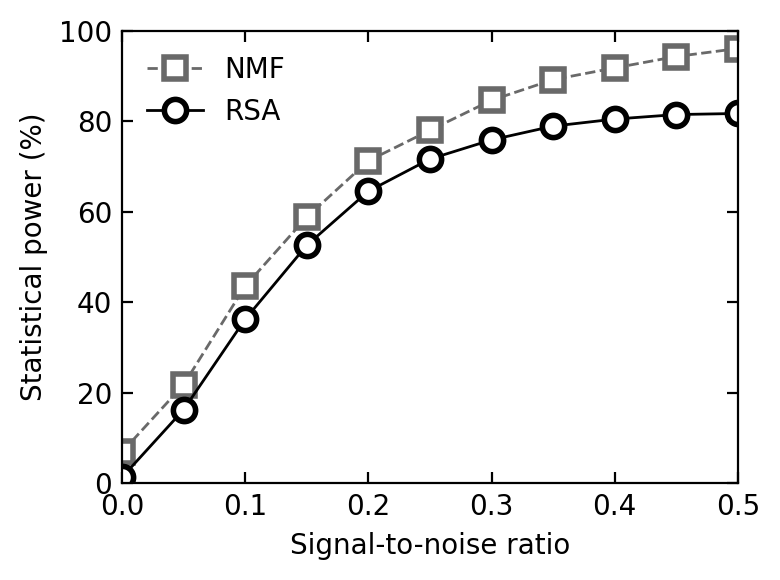

In [35]:
results_df = pd.read_csv(
    "/LOCAL/fmahner/similarity-factorization/results/benchmarks/hypothesis_tests.csv"
)

results_df = results_df[results_df["Method"] != "NMF Denoised"]
power_df = results_df.groupby(["SNR", "Method"])["Significant"].mean().reset_index()
power_df["Significant"] *= 100

plt.figure(figsize=(4, 3), dpi=200)

bw_colors = {
    "RSA": "black",
    "NMF": "dimgray",
}
bw_styles = {
    "RSA": ("-", "o"),
    "NMF": ("--", "s"),
}

for method in power_df["Method"].unique():
    method_df = power_df[power_df["Method"] == method]
    linestyle, marker = bw_styles.get(method, ("-", "o"))
    plt.plot(
        method_df["SNR"],
        method_df["Significant"],
        label=method,
        color=bw_colors.get(method, "black"),
        linestyle=linestyle,
        marker=marker,
        linewidth=1.0,
        markersize=8,
        markerfacecolor="white",
        markeredgewidth=2,
    )

plt.xlabel("Signal-to-noise ratio", fontsize=10)
plt.ylabel("Statistical power (%)", fontsize=10)
plt.legend(fontsize=10, frameon=False)
plt.xlim(0, power_df["SNR"].max())
plt.ylim(0, 100)
plt.tick_params(
    direction="in",
    top=True,
    right=True,
    which="both",
    labelsize=10,
    length=4,
)
plt.tight_layout()

Loaded results: (300, 9)
Methods: ['RSA' 'NMF' 'Latent']
SNR values: [np.float64(0.0), np.float64(0.0333333333333333), np.float64(0.0666666666666666), np.float64(0.1)]


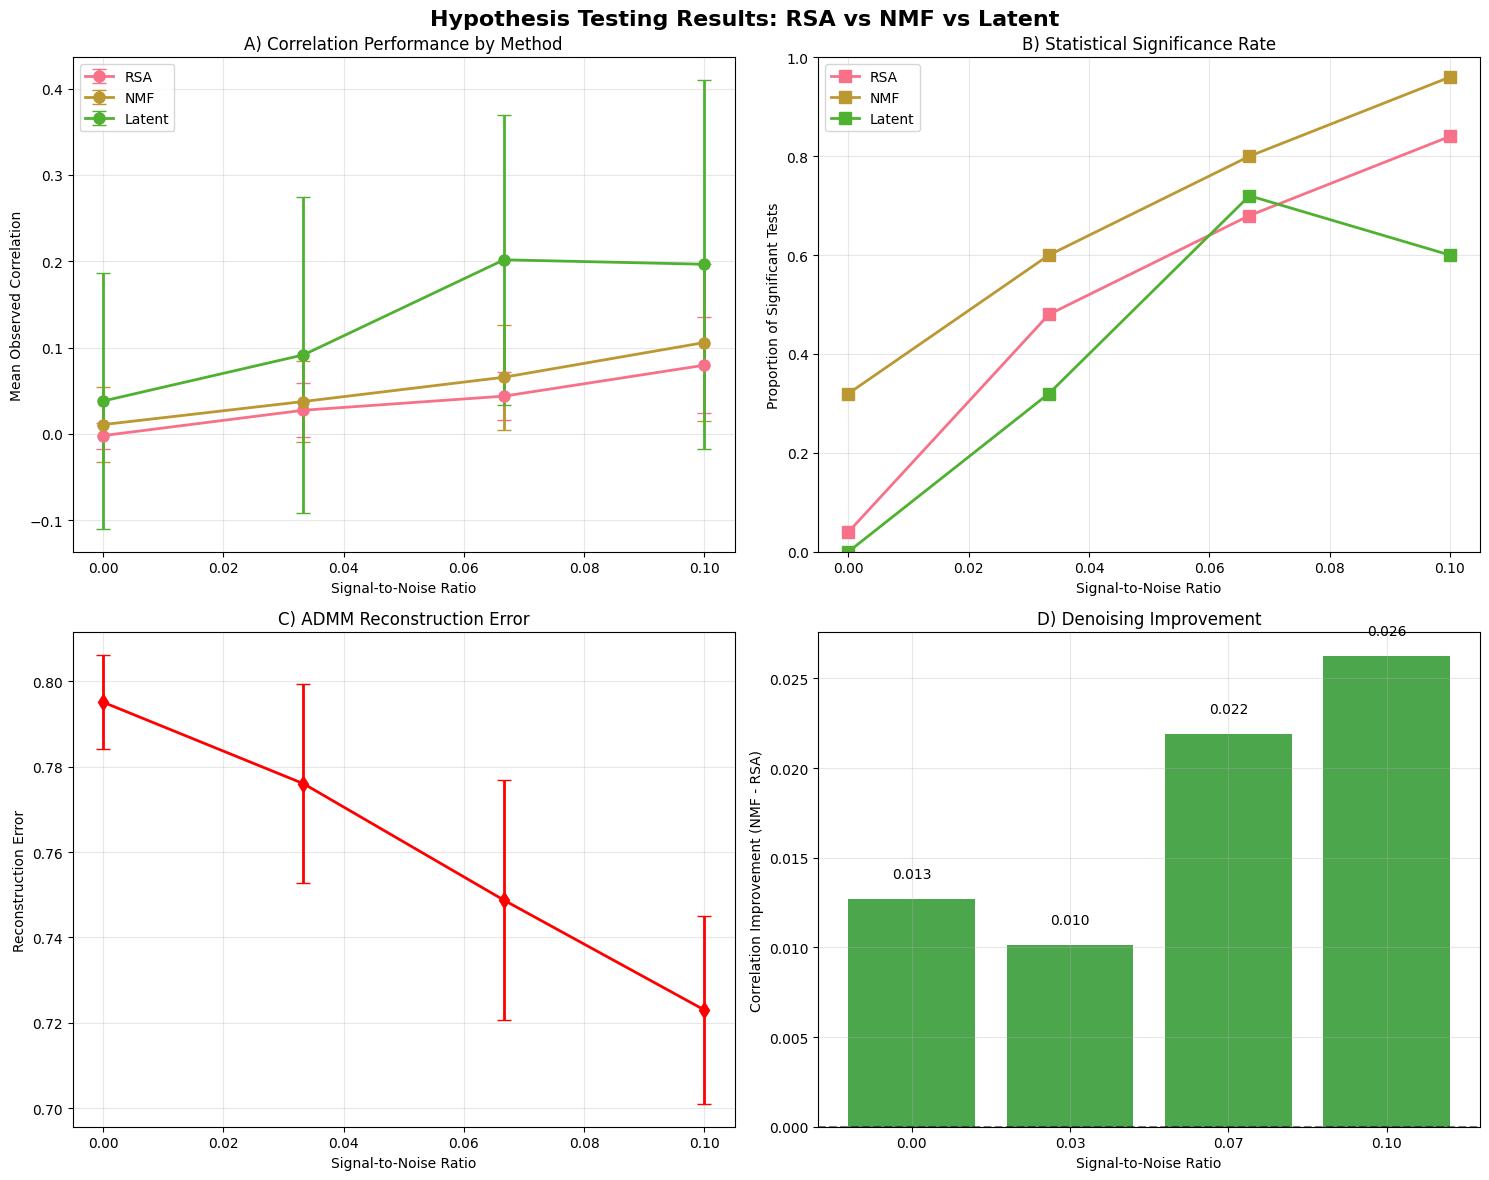


SUMMARY STATISTICS

Mean correlations by method:
          mean     std  count
Method                       
Latent  0.1319  0.1907    100
NMF     0.0548  0.0719    100
RSA     0.0371  0.0459    100

Significance rates by method:
        mean  count
Method             
Latent  0.41    100
NMF     0.67    100
RSA     0.51    100

Improvement analysis (NMF vs RSA):
SNR 0.00: RSA=-0.0021, NMF=0.0106, Improvement=0.0127 (594.7%)
SNR 0.03: RSA=0.0273, NMF=0.0374, Improvement=0.0101 (37.1%)
SNR 0.07: RSA=0.0436, NMF=0.0655, Improvement=0.0219 (50.2%)
SNR 0.10: RSA=0.0795, NMF=0.1058, Improvement=0.0263 (33.0%)

DETAILED COMPARISON TABLE
                Observed_correlation         Significant   Raw_p
                                mean     std        mean    mean
Method SNR                                                      
Latent 0.000000               0.0379  0.1486        0.00  0.2318
       0.033333               0.0915  0.1834        0.32  0.1319
       0.066667               0.201

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Load the results
results_file = "/LOCAL/fmahner/srf/results/benchmarks/hypothesis_tests_fixed.csv"
df = pd.read_csv(results_file)

print(f"Loaded results: {df.shape}")
print(f"Methods: {df['Method'].unique()}")
print(f"SNR values: {sorted(df['SNR'].unique())}")

# Set up plotting style
plt.style.use("default")
sns.set_palette("husl")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(
    "Hypothesis Testing Results: RSA vs NMF vs Latent", fontsize=16, fontweight="bold"
)

# 1. Mean correlation by method and SNR
ax1 = axes[0, 0]
summary_corr = (
    df.groupby(["Method", "SNR"])["Observed_correlation"]
    .agg(["mean", "std"])
    .reset_index()
)

for method in df["Method"].unique():
    method_data = summary_corr[summary_corr["Method"] == method]
    ax1.errorbar(
        method_data["SNR"],
        method_data["mean"],
        yerr=method_data["std"],
        marker="o",
        linewidth=2,
        markersize=8,
        label=method,
        capsize=5,
    )

ax1.set_xlabel("Signal-to-Noise Ratio")
ax1.set_ylabel("Mean Observed Correlation")
ax1.set_title("A) Correlation Performance by Method")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Significance rate by method and SNR
ax2 = axes[0, 1]
summary_sig = df.groupby(["Method", "SNR"])["Significant"].mean().reset_index()

for method in df["Method"].unique():
    method_data = summary_sig[summary_sig["Method"] == method]
    ax2.plot(
        method_data["SNR"],
        method_data["Significant"],
        marker="s",
        linewidth=2,
        markersize=8,
        label=method,
    )

ax2.set_xlabel("Signal-to-Noise Ratio")
ax2.set_ylabel("Proportion of Significant Tests")
ax2.set_title("B) Statistical Significance Rate")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

# 3. Reconstruction error vs SNR (for NMF method)
ax3 = axes[1, 0]
nmf_data = df[df["Method"] == "NMF"]
summary_rec = nmf_data.groupby("SNR")["Rec_error"].agg(["mean", "std"]).reset_index()

ax3.errorbar(
    summary_rec["SNR"],
    summary_rec["mean"],
    yerr=summary_rec["std"],
    marker="d",
    linewidth=2,
    markersize=8,
    color="red",
    capsize=5,
)
ax3.set_xlabel("Signal-to-Noise Ratio")
ax3.set_ylabel("Reconstruction Error")
ax3.set_title("C) ADMM Reconstruction Error")
ax3.grid(True, alpha=0.3)

# 4. Comparison: RSA vs NMF correlation
ax4 = axes[1, 1]
rsa_data = df[df["Method"] == "RSA"].groupby("SNR")["Observed_correlation"].mean()
nmf_data = df[df["Method"] == "NMF"].groupby("SNR")["Observed_correlation"].mean()

snr_values = sorted(df["SNR"].unique())
improvement = nmf_data.values - rsa_data.values

bars = ax4.bar(
    range(len(snr_values)),
    improvement,
    color=["red" if x < 0 else "green" for x in improvement],
    alpha=0.7,
)
ax4.set_xticks(range(len(snr_values)))
ax4.set_xticklabels([f"{snr:.2f}" for snr in snr_values])
ax4.set_xlabel("Signal-to-Noise Ratio")
ax4.set_ylabel("Correlation Improvement (NMF - RSA)")
ax4.set_title("D) Denoising Improvement")
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color="black", linestyle="--", alpha=0.5)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, improvement)):
    ax4.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.001 * np.sign(val),
        f"{val:.3f}",
        ha="center",
        va="bottom" if val > 0 else "top",
    )

plt.tight_layout()
plt.savefig(
    "/LOCAL/fmahner/srf/results/benchmarks/hypothesis_results_plot.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Print summary statistics
print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

print("\nMean correlations by method:")
corr_summary = df.groupby("Method")["Observed_correlation"].agg(
    ["mean", "std", "count"]
)
print(corr_summary.round(4))

print("\nSignificance rates by method:")
sig_summary = df.groupby("Method")["Significant"].agg(["mean", "count"])
print(sig_summary.round(4))

print("\nImprovement analysis (NMF vs RSA):")
for snr in sorted(df["SNR"].unique()):
    rsa_corr = df[(df["Method"] == "RSA") & (df["SNR"] == snr)][
        "Observed_correlation"
    ].mean()
    nmf_corr = df[(df["Method"] == "NMF") & (df["SNR"] == snr)][
        "Observed_correlation"
    ].mean()
    improvement = nmf_corr - rsa_corr
    percent_improvement = (improvement / abs(rsa_corr)) * 100 if rsa_corr != 0 else 0
    print(
        f"SNR {snr:.2f}: RSA={rsa_corr:.4f}, NMF={nmf_corr:.4f}, "
        f"Improvement={improvement:.4f} ({percent_improvement:.1f}%)"
    )

# Create a simple comparison table
print("\n" + "=" * 60)
print("DETAILED COMPARISON TABLE")
print("=" * 60)

comparison_table = (
    df.groupby(["Method", "SNR"])
    .agg(
        {
            "Observed_correlation": ["mean", "std"],
            "Significant": "mean",
            "Raw_p": "mean",
        }
    )
    .round(4)
)

print(comparison_table)